### Edgar Moises Hernandez-Gonzalez
#### 28-08-20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 720x672
##### Explorar

In [1]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (f1_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [5]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [6]:
# todos los canales
x = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/MeCa_car_10_3.csv", header=None)

# etiquetas
y = pd.read_csv("/content/drive/My Drive/MentalCalculation/Datos/EtiquetasMeCa10JAMG-03.csv", header=None).values

In [7]:
#class_names = ['left hand', 'right hand', 'both feet', 'tongue']
class_names = ['reposo', 'cálculo']

In [9]:
print(x.shape)
print(y.shape)

(328, 43008)
(328, 1)


In [10]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples = len(y)

print("n_samples:", n_samples)

n_samples: 328


In [11]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y))

print("n_classes:", n_classes)

n_classes: 2


In [12]:
# unir 32 canales y resize de tamaño proporcional
def unir_escalogramas_vertical(data):
  dim = (672, 720) #ancho, alto
  fs = 512
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],720,672))
  temporal = np.zeros((1440,1344))
  for i in range(data.shape[0]): #n muestras
    for j in range(32): #n canales
      sig = data.iloc[i, j*1344:(j+1)*1344]
      #sig = sig[160:1184]
      #escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / 512))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
# llamar a unir_escalogramas_vertical
inicio = time.time()

x = unir_escalogramas_vertical(x)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
Tiempo: 437.3388509750366


In [14]:
print(x.shape)

(328, 720, 672)


In [15]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

109.22623076896265
0.005082614417234349
3.5613646884757464


In [16]:
# convertir a float
x = x.astype('float32')

# escalar los valores en un rango de 0 a 1 (normalizar)
x /= np.ceil(np.max(x))

In [17]:
print(np.max(x))
print(np.min(x))
print(np.mean(x))

0.99296576
4.6205583e-05
0.03237607


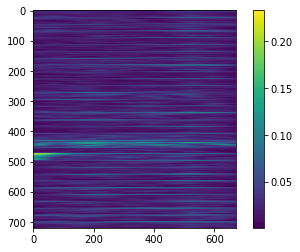

In [18]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.show()

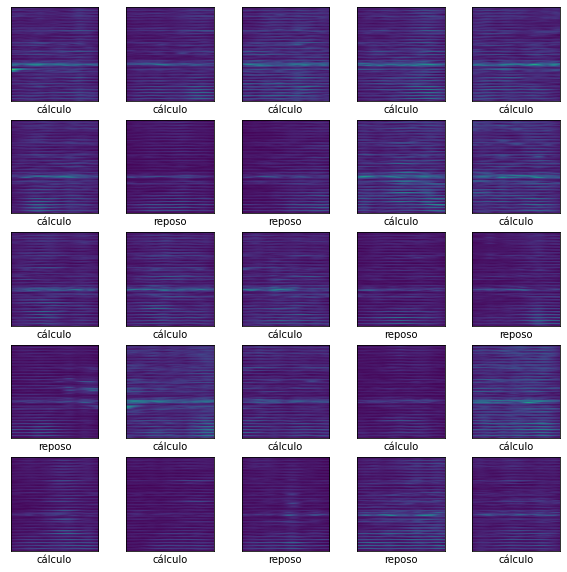

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(class_names[y[i,0]])
plt.show()

In [25]:
# convertir de 3D a 5D
x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2], 1))

print(x.shape)

(328, 1, 720, 672, 1)


In [30]:
skf = StratifiedKFold(n_splits = 5)

In [26]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(8, (15,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(8, (15,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8, activation='tanh', dropout=0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model


Iteration: 1
loss:  0.2624092400074005
accuracy:  0.939393937587738
f1: 0.9332659251769464
confusion matrix:
 [[21  4]
 [ 0 41]]
AUC 0.9053658536585365


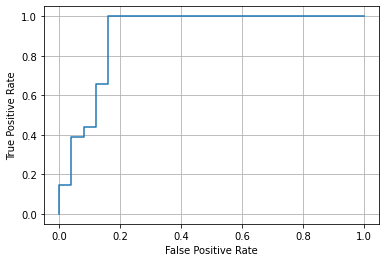

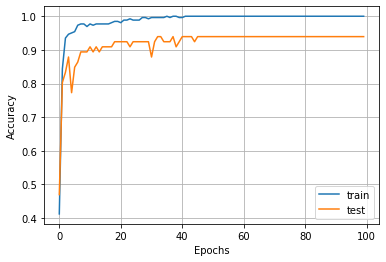

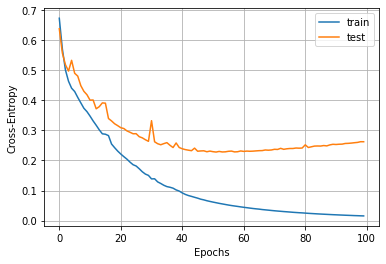


Iteration: 2
loss:  0.01733536273241043
accuracy:  1.0
f1: 1.0
confusion matrix:
 [[25  0]
 [ 0 41]]
AUC 1.0


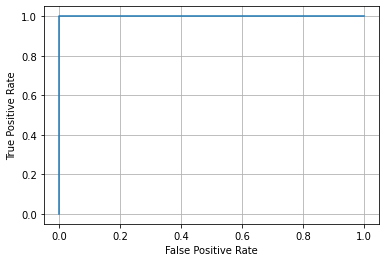

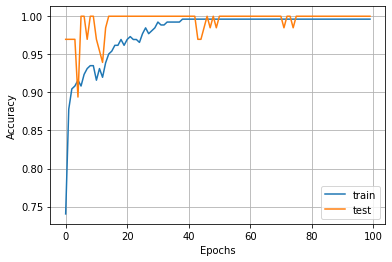

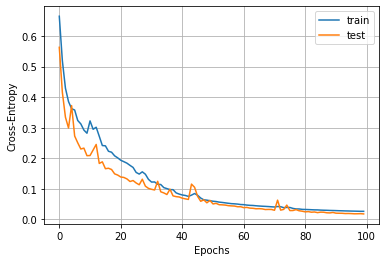


Iteration: 3
loss:  0.1720207929611206
accuracy:  0.939393937587738
f1: 0.9356097560975609
confusion matrix:
 [[23  3]
 [ 1 39]]
AUC 0.9913461538461538


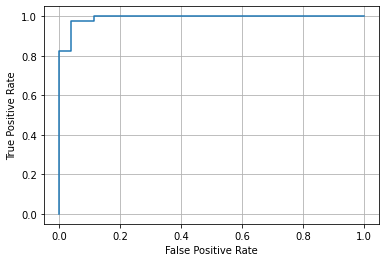

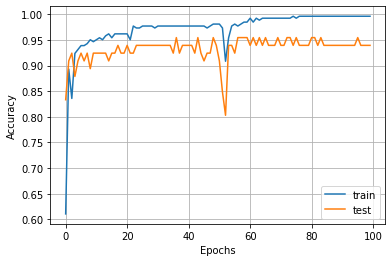

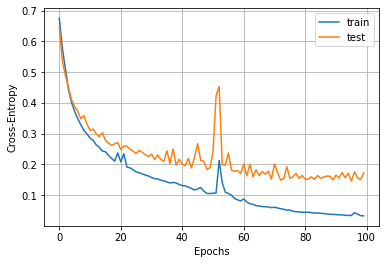


Iteration: 4
loss:  0.09281177073717117
accuracy:  0.9846153855323792
f1: 0.9836230788611741
confusion matrix:
 [[24  1]
 [ 0 40]]
AUC 0.989


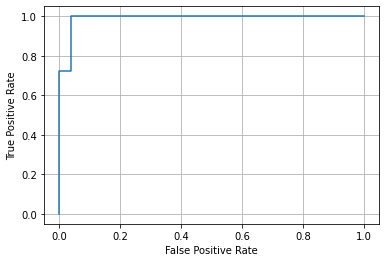

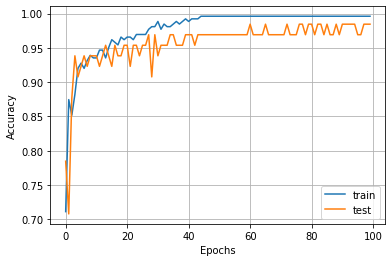

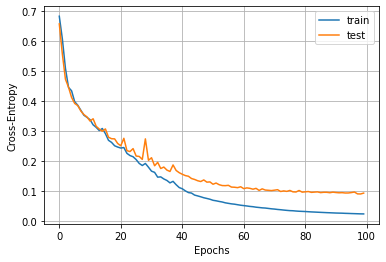


Iteration: 5
loss:  0.2382323294878006
accuracy:  0.9230769276618958
f1: 0.9181153943058704
confusion matrix:
 [[22  3]
 [ 2 38]]
AUC 0.976


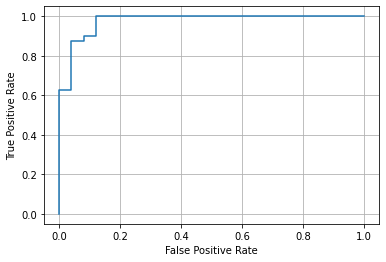

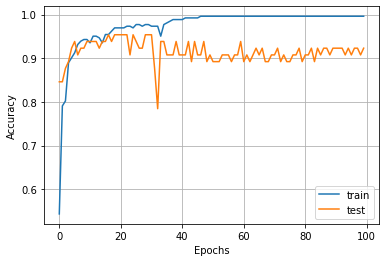

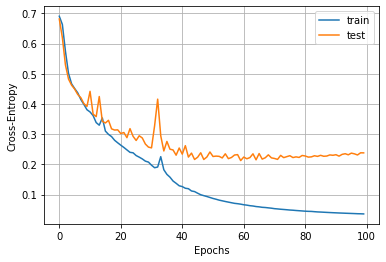


Resultados:
loss: [0.2624092400074005, 0.01733536273241043, 0.1720207929611206, 0.09281177073717117, 0.2382323294878006]
accuracy: [0.939393937587738, 1.0, 0.939393937587738, 0.9846153855323792, 0.9230769276618958]
f1: [0.9332659251769464, 1.0, 0.9356097560975609, 0.9836230788611741, 0.9181153943058704]
auc: [0.9053658536585365, 1.0, 0.9913461538461538, 0.989, 0.976]
Tiempo: 518.9704875946045


In [34]:
inicio = time.time()
array_loss = []
array_acc = []
array_f1 = []
array_auc = []
i = 0
for iTrain, jTest in skf.split(x, y):
  print("\nIteration:", i + 1)
  x_train, x_test = x[iTrain], x[jTest]
  y_train, y_test = y[iTrain], y[jTest]

  model = CNN_2D_LSTM_TD()
  
  history = model.fit(x_train, y_train, epochs=100, batch_size=20,
                      validation_data=(x_test, y_test),
                      verbose=0)#, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  f1 = f1_score(y_test, y_pred, average='macro')
  array_f1.append(f1)
  print("f1:", f1)
  
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades2 = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades2)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades2)
  array_auc.append(auc)

  print("AUC", auc)
  plt.plot(fpr, tpr)
  plt.grid()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
  i += 1
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("f1:", array_f1)
print("auc:", array_auc)
fin = time.time()
print("Tiempo:", fin - inicio)

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 1, 720, 672, 8)    368       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 1, 360, 336, 8)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 1, 360, 336, 8)    2888      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 1, 180, 168, 8)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 1, 241920)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 7741728   
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [38]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean F1: %.4f" % np.mean(array_f1))
print("std: (+/- %.4f)" % np.std(array_f1))
print("Mean auc: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max F1: %.4f" % np.max(array_f1))
print("Max auc: %.4f" % np.max(array_auc))

Mean Accuracy: 0.9573
std: (+/- 0.0296)
Mean F1: 0.9541
std: (+/- 0.0318)
Mean auc: 0.9723
std: (+/- 0.0344)
Max Accuracy: 1.0000
Max F1: 1.0000
Max auc: 1.0000


In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i,0], img[i]
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img.reshape(720,672))

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [40]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i,0]
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [43]:
num_test = 28
print("Etiqueta verdadera", y_test[num_test])
prediccion = model.predict(x_test[num_test].reshape(1,1,720,672,1))
print("Etiqueta predicha", prediccion.argmax())

Etiqueta verdadera [1]
Etiqueta predicha 1


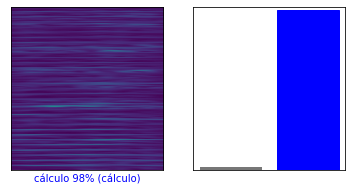

In [44]:
i = num_test
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, probabilidades, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, probabilidades,  y_test)
plt.show()

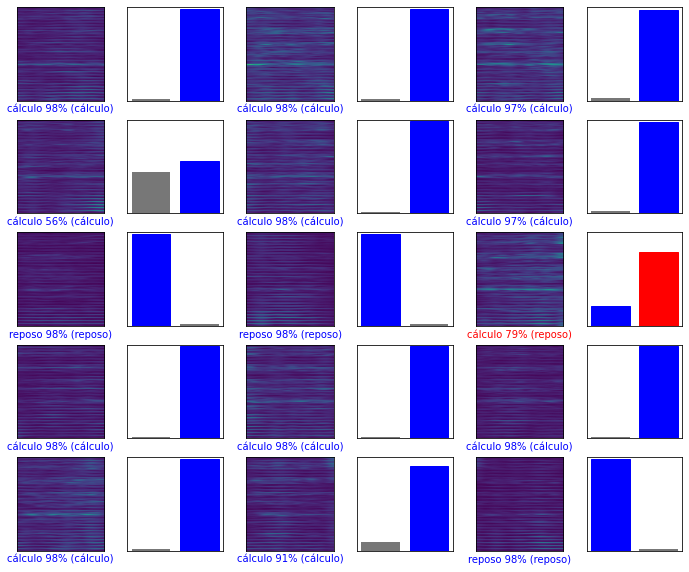

In [45]:
#Graficar imagenes, etiqueta predicha y etiqueta verdadera
#Correcta en azul, incorrecta en rojo
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, probabilidades, y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, probabilidades, y_test)
plt.show()